<a href="https://colab.research.google.com/github/firarru/Analisis-Deret-Waktu/blob/main/Kelompok_4_ARIMA_Harga_Emas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Set Up Package**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

from scipy.stats import boxcox
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
from math import sqrt

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import pickle
import warnings
warnings.filterwarnings('ignore')

# **Load Data**

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/firarru/Analisis-Deret-Waktu/refs/heads/main/Dataset/gold_rate_history.csv')
df.head()

,Date,Country,State,Location,Pure Gold (24 k),Standard Gold (22 K)
0,1/2/2006,India,Tamilnadu,Chennai,768.0,711.0
1,1/3/2006,India,Tamilnadu,Chennai,770.5,713.0
2,1/4/2006,India,Tamilnadu,Chennai,784.5,726.0
3,1/5/2006,India,Tamilnadu,Chennai,782.5,725.0
4,1/6/2006,India,Tamilnadu,Chennai,776.0,719.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4971 entries, 0 to 4970
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  4971 non-null   object 
 1   Country               4971 non-null   object 
 2   State                 4971 non-null   object 
 3   Location              4971 non-null   object 
 4   Pure Gold (24 k)      4971 non-null   float64
 5   Standard Gold (22 K)  4971 non-null   float64
dtypes: float64(2), object(4)
memory usage: 233.1+ KB


# **Preprocessing**

In [4]:
df1 = df[['Date', 'Standard Gold (22 K)']]
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4971 entries, 0 to 4970
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  4971 non-null   object 
 1   Standard Gold (22 K)  4971 non-null   float64
dtypes: float64(1), object(1)
memory usage: 77.8+ KB


In [5]:
total_null = df1['Standard Gold (22 K)'].isnull().sum()
total_rows = len(df1)
percentage_null = (total_null / total_rows) * 100

print(f"Total missing values in 'Standard Gold': {total_null}")
print(f"Percentage of missing values in 'Standard Gold': {percentage_null:.2f}%")

Total missing values in 'Standard Gold': 0
Percentage of missing values in 'Standard Gold': 0.00%


In [6]:
df1['Date'] = pd.to_datetime(df1['Date'])
df1.set_index(pd.to_datetime(df1['Date']), inplace=True)
df1.drop('Date', axis=1, inplace=True)
df1.tail()

,Standard Gold (22 K)
Date,
2020-10-06,4860.0
2020-10-07,4806.0
2020-10-08,4810.0
2020-10-09,4850.0
2020-10-10,4881.0


In [7]:
df1.describe()

,Standard Gold (22 K)
count,4971.000000
mean,2366.233052
std,941.018672
min,711.000000
25%,1568.500000
50%,2610.000000
75%,2875.000000
max,5416.000000


# **Plot Data**

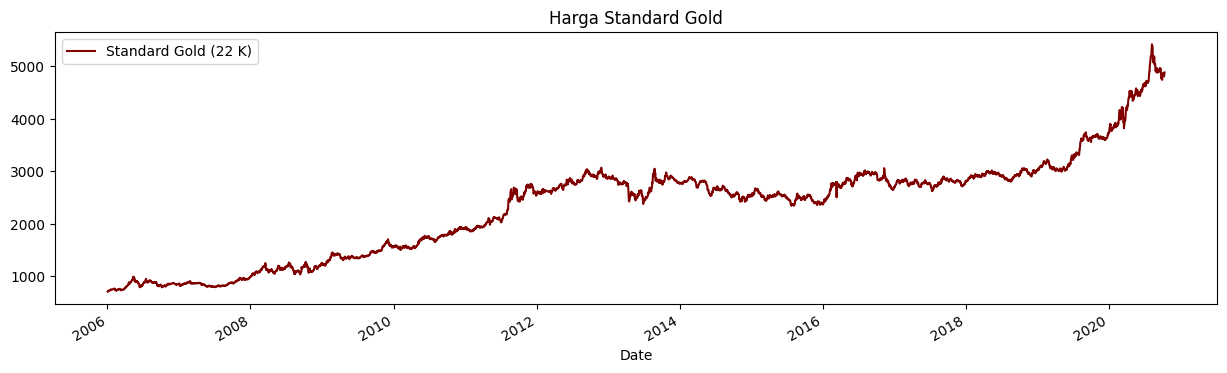

In [8]:
df1.plot(color='maroon', figsize=(15,4))
plt.title('Harga Standard Gold')
plt.savefig('Harga Standard Gold.png')
plt.show()

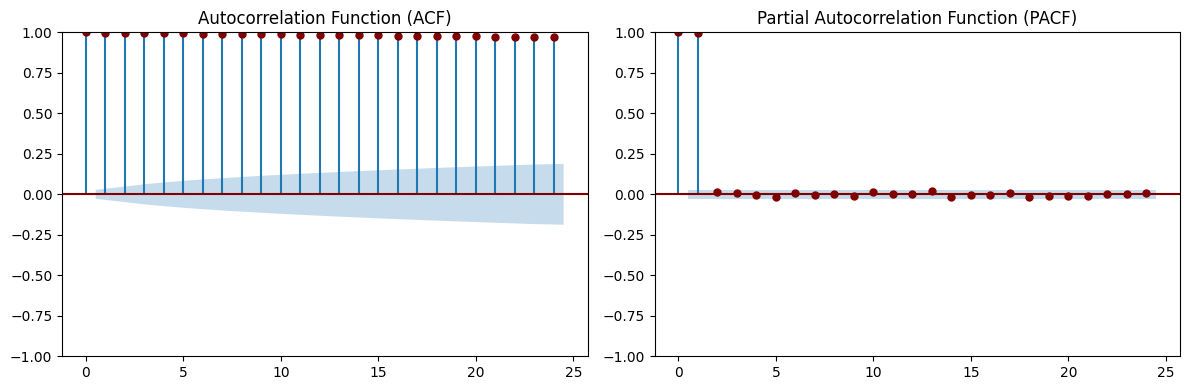

In [9]:
# Create subplots
significance_level = 0.05
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# ACF plot with significant lines
sm.graphics.tsa.plot_acf(df1, lags=24, alpha=significance_level,ax=ax1, color='maroon')
ax1.set_title('Autocorrelation Function (ACF)')

# PACF plot with significant lines
sm.graphics.tsa.plot_pacf(df1, lags=24, alpha=significance_level,ax=ax2, color='maroon')
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

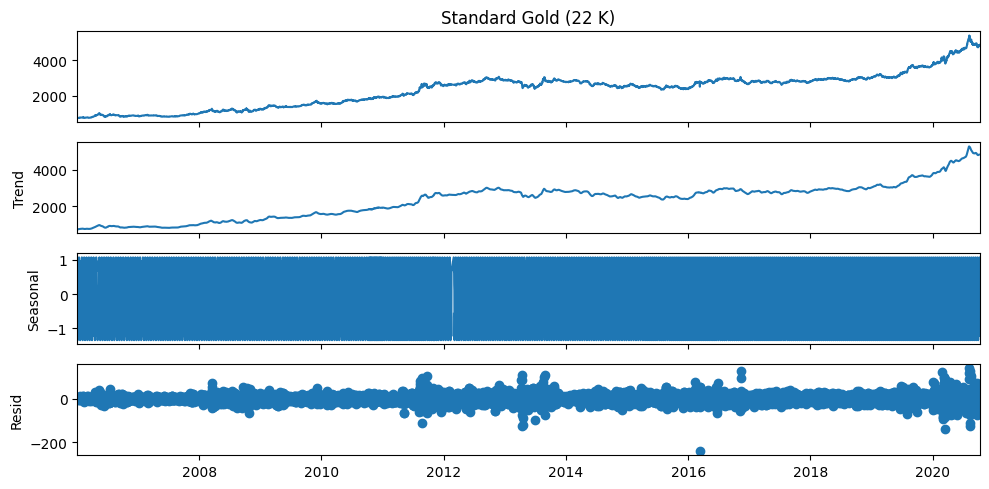

In [10]:
plt.rcParams['figure.figsize'] = 10, 5
decomposition = seasonal_decompose(df1['Standard Gold (22 K)'], period =12, model = 'additive')
decomposition.plot()
# plt.savefig('Trend, Seasonal, Residual Graph.png')
plt.show()

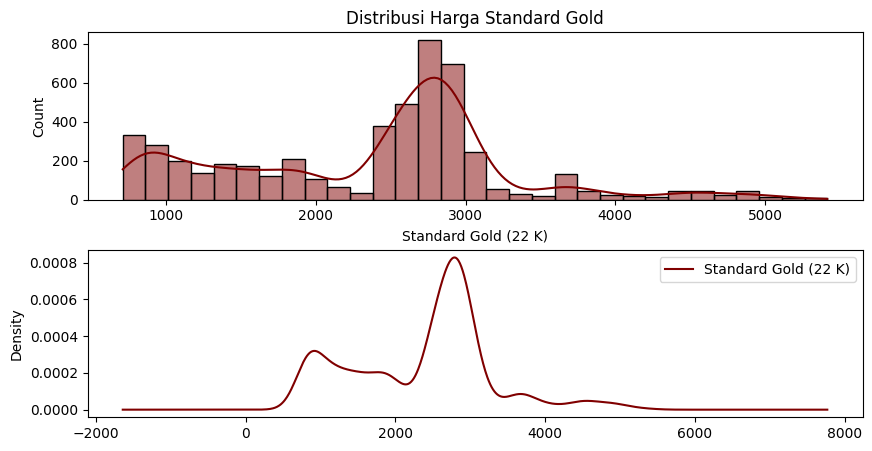

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(10,5))
sns.histplot(df1['Standard Gold (22 K)'], kde=True, color='maroon', ax=ax1)
ax1.set_title('Distribusi Harga Standard Gold')
df1.plot(kind='kde', ax=ax2, color='maroon')
plt.subplots_adjust(hspace=0.3)
plt.show()

# **Stasioneritas Data Terhadap Variansi dan Transformasi Menggunakan Box Cox**

In [12]:
df1_boxcox, best_lambda = boxcox(df1['Standard Gold (22 K)'])
print('Nilai 𝜆(lambda) optimal', best_lambda)

Nilai 𝜆(lambda) optimal 0.8147855579209338


In [13]:
df1_boxcox

array([ 257.36691973,  257.95944863,  261.80343009, ..., 1226.53785035,
       1234.85051099, 1241.28408938])

Karena 𝜆 yang dihasilkan adalah -0.57 atau -0.5 maka rumus transformasi yang dipakai adalah 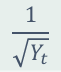

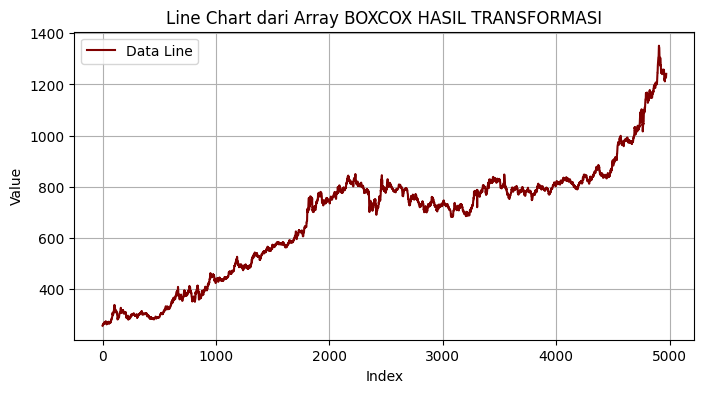

In [14]:
plt.figure(figsize=(8, 4))
plt.plot(df1_boxcox, linestyle='-', color='maroon', label='Data Line')
plt.title('Line Chart dari Array BOXCOX HASIL TRANSFORMASI')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
print('Batas bawah = ', df1_boxcox.min())
print('Batas atas = ', df1_boxcox.max())

Batas bawah =  257.3669197320712
Batas atas =  1351.1694506903625


# **Stasioneritas Data Terhadap Mean Menggunakan Uji ADF**

In [16]:
def test_stationarity(timeseries):
  result = adfuller(timeseries)
  print('ADF Statistic: ', result[0])
  print('p-value: ', result[1])
  print('Critical Values: ')
  for key, value in result[4].items():
    print('\t', key, ':', value)

  if result[1] <= 0.05:
    print('Kesimpulan : Data adalah stasioner.')
  else:
    print('Kesimpulan : Data tidak stasioner.')

In [17]:
# Uji stasionaritas pada data setelah transformasi
print("Uji stasionaritas sebelum transformasi:")
test_stationarity(df1)

print("\nUji stasionaritas setelah transformasi Box-Cox:")
test_stationarity(df1_boxcox)

Uji stasionaritas sebelum transformasi:
ADF Statistic:  0.5425885223796896
p-value:  0.9861116435386643
Critical Values: 
	 1% : -3.4316674956516784
	 5% : -2.8621221897344484
	 10% : -2.567079900452355
Kesimpulan : Data tidak stasioner.

Uji stasionaritas setelah transformasi Box-Cox:
ADF Statistic:  0.27596930003368864
p-value:  0.9762147080226039
Critical Values: 
	 1% : -3.431666699811146
	 5% : -2.862121838137364
	 10% : -2.5670797132833347
Kesimpulan : Data tidak stasioner.


# **Differencing**


In [18]:
df1_diff = df1.diff().dropna()
print("Uji stasionaritas setelah differencing pertama:")
test_stationarity(df1_diff['Standard Gold (22 K)'])

Uji stasionaritas setelah differencing pertama:
ADF Statistic:  -33.82011837750388
p-value:  0.0
Critical Values: 
	 1% : -3.4316674956516784
	 5% : -2.8621221897344484
	 10% : -2.567079900452355
Kesimpulan : Data adalah stasioner.


df1.diff() : Code tersebut merupakan differencing non seasonal.

Jika ingin melakukan differencing secara seasonal, maka perlu didefinisikan ke dalam diff() berapa periode seasonal yang dipakai

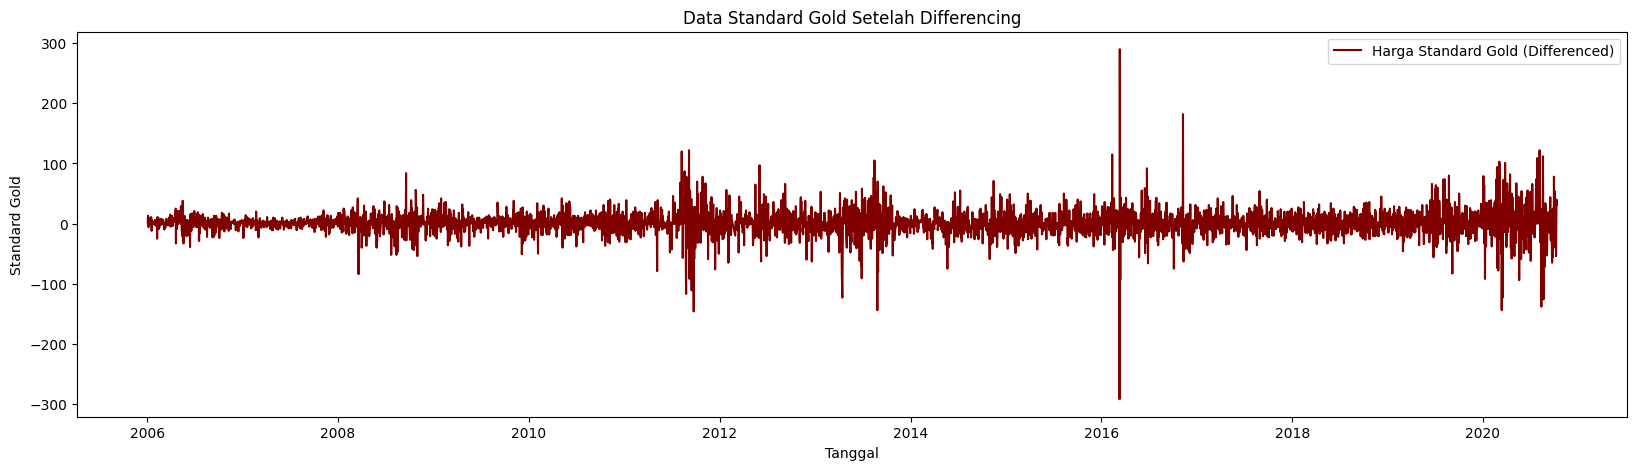

In [19]:
# Visualisasi data setelah differencing
plt.figure(figsize=(20,5))
plt.plot(df1_diff, label='Harga Standard Gold (Differenced)', color='maroon')
plt.title('Data Standard Gold Setelah Differencing')
plt.xlabel('Tanggal')
plt.ylabel('Standard Gold')
plt.legend()
plt.show()

### Plot ACF dan PACF

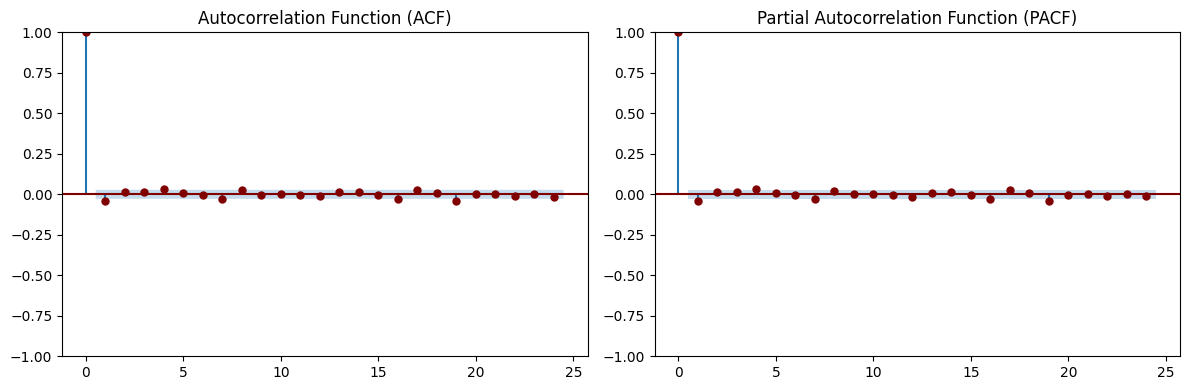

In [20]:
# Create subplots
significance_level = 0.05
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# ACF plot with significant lines
sm.graphics.tsa.plot_acf(df1_diff, lags=24, alpha=significance_level,ax=ax1, color='maroon')
ax1.set_title('Autocorrelation Function (ACF)')

# PACF plot with significant lines
sm.graphics.tsa.plot_pacf(df1_diff, lags=24, alpha=significance_level,ax=ax2, color='maroon')
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

### Identifikasi Model

In [21]:
pip install pmdarima

In [22]:
from pmdarima import auto_arima
model = auto_arima(
    df1,
    start_p=0, max_p=5,  # Rentang untuk parameter p
    start_q=0, max_q=5,  # Rentang untuk parameter q
    d=None,              # Deteksi tingkat differencing otomatis
    seasonal=False,      # Non-musiman (ubah ke True jika musiman)
    trace=True,          # Menampilkan log pemrosesan
    error_action='ignore', # Abaikan error
    suppress_warnings=True, # Sembunyikan peringatan
    stepwise=True         # Gunakan pencarian parameter stepwise
)

print("Best ARIMA Order:", model.order)
print("AIC Score:", model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=44010.612, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=44004.590, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=44004.852, Time=2.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=44017.135, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=44005.395, Time=2.49 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=44005.739, Time=7.75 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=44004.375, Time=11.96 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=44005.767, Time=16.40 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=44003.736, Time=10.98 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=44004.071, Time=3.57 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=44005.718, Time=11.78 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=44005.761, Time=2.86 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=44005.468, Time=7.73 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=44005.365, Time=14.18 sec
 ARIMA(2,1,2)(

# **Estimasi Parameter & Uji LJung Box**

In [23]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4971
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -21995.868
Date:                Tue, 24 Dec 2024   AIC                          44003.736
Time:                        11:18:43   BIC                          44042.803
Sample:                             0   HQIC                         44017.432
                               - 4971                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5953      0.253      2.357      0.018       0.100       1.090
ar.L1          0.8310      0.129      6.439      0.000       0.578       1.084
ar.L2         -0.5366      0.112     -4.775      0.000      -0.757      -0.316
ma.L1         -0.8707      0.128     -6.819      0.000      -1.121      -0.620
ma.L2          0.5780      0.108      5.339      0.000       0.366       0.790
sigma2       409.1351      2.519    162.431      0.000     404.198     414.072
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            119729.48
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               3.26   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# **Uji Kenormalan sisaan dengan menggunakan Kolmogorof-Smirnov**

In [24]:
from scipy import stats

# Ambil data dari kolom setelah differencing
data = df1_diff['Standard Gold (22 K)']  # Pastikan df1_diff adalah DataFrame

# Uji Kolmogorov-Smirnov
statistic, p_value = stats.kstest(data, 'norm', args=(data.mean(), data.std()))

# Output hasil uji
print(f"Statistik K-S: {statistic}")
print(f"P-Value: {p_value}")

# Kesimpulan
if p_value < 0.05:
    print("Tolak H0: Data tidak berdistribusi normal.")
else:
    print("Gagal tolak H0: Data berdistribusi normal.")

Statistik K-S: 0.11618238412898876
P-Value: 6.652339747782929e-59
Tolak H0: Data tidak berdistribusi normal.


# **Forecasting**

In [25]:
df1_diff.shape

(4970, 1)

In [26]:
train = df1['Standard Gold (22 K)'][:-200]
test = df1['Standard Gold (22 K)'][-200:]
print(train.shape, test.shape)

(4771,) (200,)


In [27]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(1, 2, 1))
fitted = model.fit()

# Forecast
forecast_obj = fitted.get_forecast(steps=len(test))
fc = forecast_obj.predicted_mean
conf = forecast_obj.conf_int(alpha=0.05)  # 95% confidence interval

print(conf)

      lower Standard Gold (22 K)  upper Standard Gold (22 K)
4771                 3974.768485                 4049.593070
4772                 3962.149713                 4064.268648
4773                 3952.017107                 4075.765058
4774                 3943.538856                 4085.656647
4775                 3936.112843                 4094.492457
...                          ...                         ...
4966                 3649.039411                 4650.882305
4967                 3648.408127                 4652.923623
4968                 3647.779767                 4654.962016
4969                 3647.154309                 4656.997507
4970                 3646.531730                 4659.030120

[200 rows x 2 columns]


In [28]:
#Memulai prediksi dari len(train) (indeks terakhir data train) hingga akhir data test
predictions = fitted.predict(len(train), len(train) + len(test) - 1, typ='levels').rename('Predictions')
predictions

,Predictions
4771,4012.180777
4772,4013.209181
4773,4013.891082
4774,4014.597751
4775,4015.302650
...,...
4966,4149.960858
4967,4150.665875
4968,4151.370892
4969,4152.075908


In [29]:
# Loop untuk mencetak hasil prediksi dan nilai sebenarnya
for i in range(len(predictions)):
    predicted_value = predictions.iloc[i]
    expected_value = test.iloc[i]

    print(f"predicted = {predicted_value:<6.5}, expected = {expected_value:<6.5}")

predicted = 4012.2, expected = 4016.0
predicted = 4013.2, expected = 4117.0
predicted = 4013.9, expected = 4168.0
predicted = 4014.6, expected = 4201.0
predicted = 4015.3, expected = 4201.0
predicted = 4016.0, expected = 4219.0
predicted = 4016.7, expected = 4180.0
predicted = 4017.4, expected = 4167.0
predicted = 4018.1, expected = 4165.0
predicted = 4018.8, expected = 4232.0
predicted = 4019.5, expected = 4262.0
predicted = 4020.2, expected = 4262.0
predicted = 4020.9, expected = 4248.0
predicted = 4021.6, expected = 4300.0
predicted = 4022.4, expected = 4343.0
predicted = 4023.1, expected = 4368.0
predicted = 4023.8, expected = 4403.0
predicted = 4024.5, expected = 4403.0
predicted = 4025.2, expected = 4403.0
predicted = 4025.9, expected = 4440.0
predicted = 4026.6, expected = 4522.0
predicted = 4027.3, expected = 4517.0
predicted = 4028.0, expected = 4520.0
predicted = 4028.7, expected = 4479.0
predicted = 4029.4, expected = 4477.0
predicted = 4030.1, expected = 4477.0
predicted = 

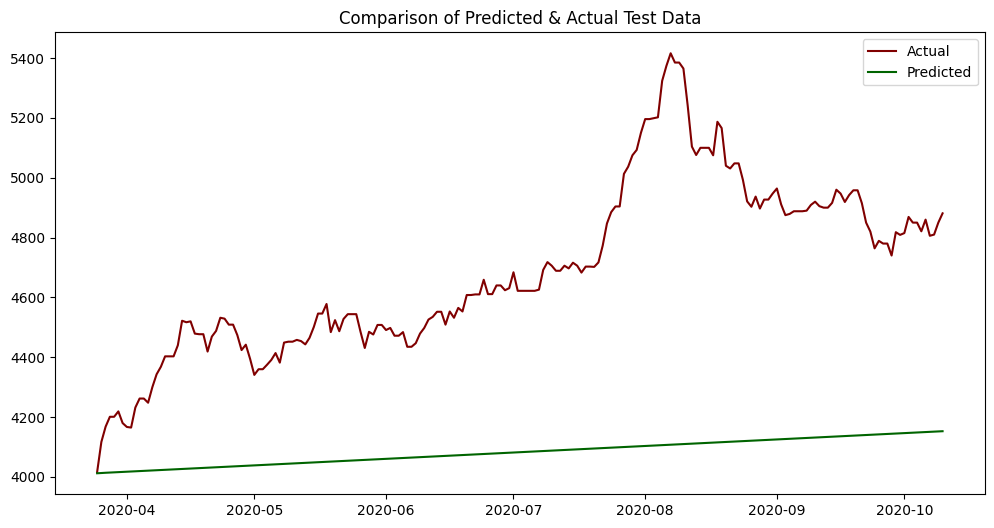

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual', color='maroon')
plt.plot(test.index, predictions, label='Predicted', color='darkgreen')
plt.title('Comparison of Predicted & Actual Test Data')
plt.legend()
plt.show()

In [31]:
fc.head()

,predicted_mean
4771,4012.180777
4772,4013.209181
4773,4013.891082
4774,4014.597751
4775,4015.302650


In [32]:
fc_series = pd.Series(fc.values, index=test.index)
lower_series = pd.Series(conf['lower Standard Gold (22 K)'], index=test.index)
upper_series = pd.Series(conf['upper Standard Gold (22 K)'], index=test.index)

In [33]:
print(fc.index)
print(test.index)

RangeIndex(start=4771, stop=4971, step=1)
DatetimeIndex(['2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28',
               '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01',
               '2020-04-02', '2020-04-03',
               ...
               '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-04',
               '2020-10-05', '2020-10-06', '2020-10-07', '2020-10-08',
               '2020-10-09', '2020-10-10'],
              dtype='datetime64[ns]', name='Date', length=200, freq=None)


In [34]:
fc.tail()

,predicted_mean
4966,4149.960858
4967,4150.665875
4968,4151.370892
4969,4152.075908
4970,4152.780925


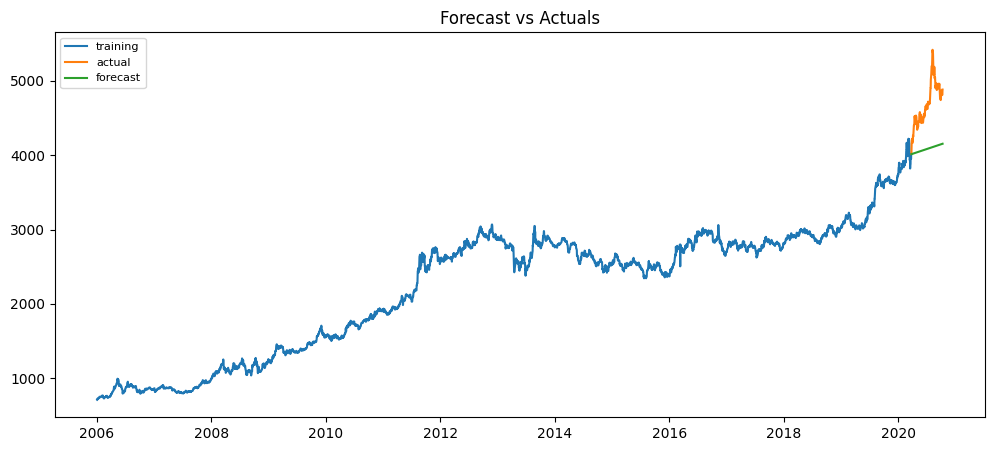

In [35]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

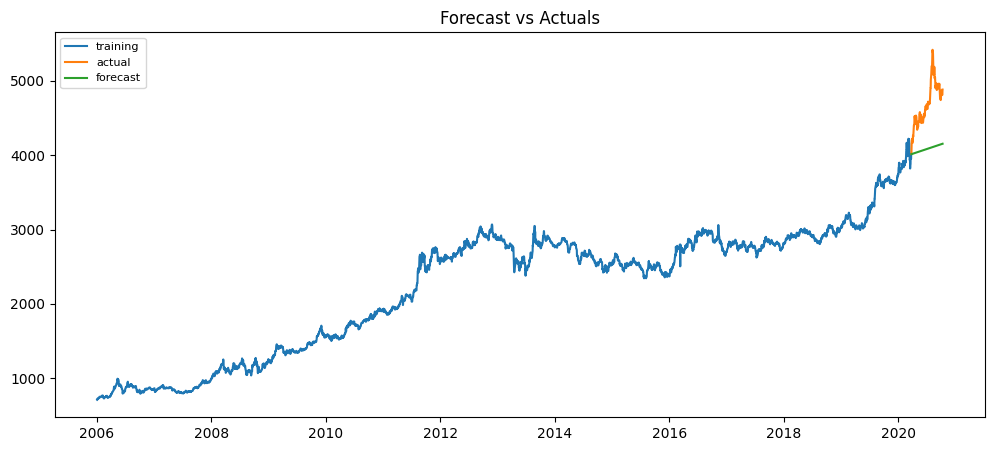

In [36]:
plt.figure(figsize=(12,5), dpi=100)

# Plot data training, actual, dan forecast
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')

# Menghapus bagian untuk confidence interval
# plt.fill_between(lower_series.index, lower_series, upper_series,
#                  color='k', alpha=0.15, label='Confidence Interval')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)

# Menampilkan grafik
plt.show()

In [37]:
print('Evaluation Results for Test Data : \n')
print(' Percenatge of R2 Score : {} %'.format(100*(r2_score(test,predictions))),'\n')
print(' Mean Squared Error : ',mean_squared_error(test,predictions),'\n')
print(' Root Mean Squared Error : ',sqrt(mean_squared_error(test,predictions)),'\n')
print(' Mean Absolute Error : ',mean_absolute_error(test,predictions),'\n')
print(' Mean Absolute Percentage Error : {0:.2f} %'.format(100*mean_absolute_percentage_error(test,predictions)),'\n')

Evaluation Results for Test Data : 

 Percenatge of R2 Score : -434.91548749686666 % 

 Mean Squared Error :  430899.10831898113 

 Root Mean Squared Error :  656.4290581007068 

 Mean Absolute Error :  606.2096504957987 

 Mean Absolute Percentage Error : 12.66 % 



## Karena Model tidak bagus, maka mengatasi masalah dengan Regresi

Fokus utama :

Memprediksi 22k Gold Price
Membuat Lag Features dari Harga Gold dengan waktu terakhir di dataset

In [38]:
NO_OF_LAG_DAYS = 14

In [39]:
def create_lag_feature(df, no_of_days):

    for day in range(1, no_of_days+1):
        df1[f"lag_{day}"] = df1["Standard Gold (22 K)"].shift(day)

    return df1

In [40]:
df_features = create_lag_feature(df1, NO_OF_LAG_DAYS)

In [41]:
lag_features =  [ col for col in df_features.columns if "lag" in col]
print(lag_features)

['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14']


In [42]:
df_lag_features = df_features[lag_features + ['Standard Gold (22 K)']].dropna()
df_lag_features.columns

Index(['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8',
       'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14',
       'Standard Gold (22 K)'],
      dtype='object')

In [43]:
NUM_PREDICTION = 500
train_df = df_lag_features[:-NUM_PREDICTION]
test_df = df_lag_features[-NUM_PREDICTION:]

print(train_df.shape, test_df.shape)

(4457, 15) (500, 15)


# **MLP Regressor**

In [44]:
from sklearn.neural_network import MLPRegressor
model = mlp = MLPRegressor(solver='lbfgs', hidden_layer_sizes=12,
                           max_iter=100, random_state=5,
                           activation="relu")

In [45]:
X_train_df = train_df[lag_features]
X_test_df = test_df[lag_features]

In [46]:
model.fit(X_train_df, train_df['Standard Gold (22 K)'])

MLPRegressor(hidden_layer_sizes=12, max_iter=100, random_state=5,
             solver='lbfgs')

In [47]:
predicted_price = model.predict(X_test_df)
test_df["22K Gold Predicted_Price"] = predicted_price

In [48]:
test_df[["Standard Gold (22 K)", "22K Gold Predicted_Price"]].head()

,Standard Gold (22 K),22K Gold Predicted_Price
Date,,
2019-05-30,3031.0,3049.636993
2019-05-31,3062.0,3035.945277
2019-06-01,3079.0,3060.833358
2019-06-02,3079.0,3073.045385
2019-06-03,3076.0,3078.993239


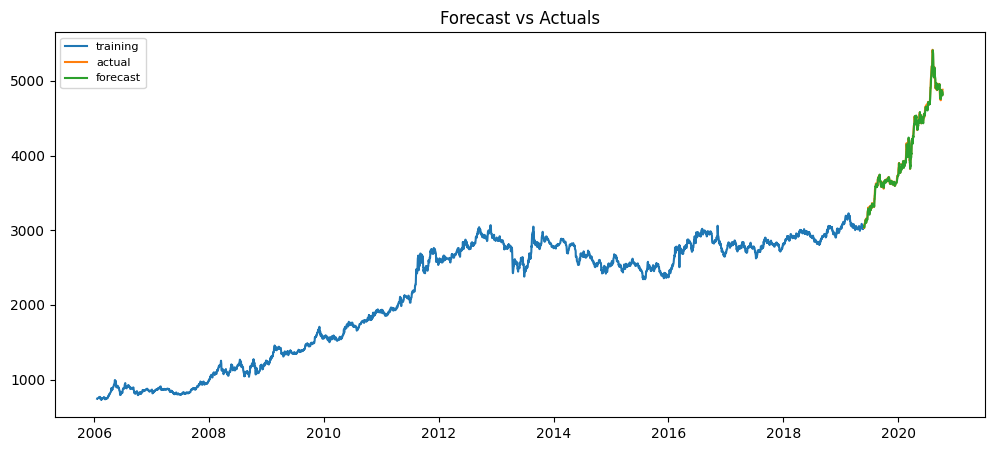

In [49]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_df['Standard Gold (22 K)'], label='training')
plt.plot(test_df['Standard Gold (22 K)'], label='actual')
plt.plot(test_df['22K Gold Predicted_Price'], label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# **Evaluasi Metrik**

In [50]:
from sklearn.metrics import mean_squared_error

In [51]:
pip install --upgrade scikit-learn

In [52]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from math import sqrt

# Calculate evaluation metrics
r2 = r2_score(test, predictions)
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, predictions)
mape = mean_absolute_percentage_error(test, predictions)

# Print the evaluation results
print('Evaluation Results for Test Data: \n')
print(f' Percentage of R² Score: {100 * r2} %\n')
print(f' Mean Squared Error: {mse}\n')
print(f' Root Mean Squared Error: {rmse}\n')
print(f' Mean Absolute Error: {mae}\n')
print(f' Mean Absolute Percentage Error: {100 * mape:.2f} %\n')

Evaluation Results for Test Data: 

 Percentage of R² Score: -434.91548749686666 %

 Mean Squared Error: 430899.10831898113

 Root Mean Squared Error: 656.4290581007068

 Mean Absolute Error: 606.2096504957987

 Mean Absolute Percentage Error: 12.66 %



In [53]:
# print('Evaluation Results for Test Data : \n')
# print(' Percenatge of R2 Score : {} %'.format(100*(r2_score(test,predictions))),'\n')
# print(' Mean Squared Error : ',mean_squared_error(test,predictions),'\n')
# print(' Root Mean Squared Error : ',sqrt(mean_squared_error(test,predictions)),'\n')
# print(' Mean Absolute Error : ',mean_absolute_error(test,predictions),'\n')
# print(' Mean Absolute Percentage Error : {0:.2f} %'.format(100*mean_absolute_percentage_error(test,predictions)),'\n')

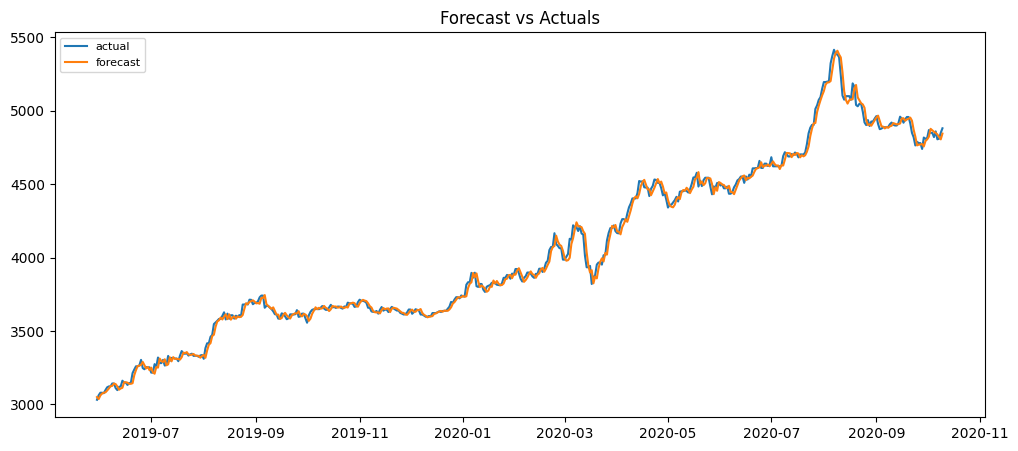

In [55]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test_df['Standard Gold (22 K)'][-NUM_PREDICTION:], label='actual')
plt.plot(test_df['22K Gold Predicted_Price'][-NUM_PREDICTION:], label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()